# Reparameterizing distributions in numpyro

Every single time I've tried to "chance" it with probabilistic methods I am once again reminded that you can't treat them like a black box. The following is a self-contained example of a pathological case so simple it almost feels like it should just work, and yet it fails miserably without intervention (in this case by reparameterizing the distributions). Part of me wonders if this all just means we need better tools or whether we just have to accept the fundamental complexity and model defensively.

In [2]:
import seaborn as sns
from jax import lax
from jax import numpy as jnp
from jax.random import PRNGKey
from matplotlib import pyplot as plt
from numpyro import deterministic, handlers, sample
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, autoguide, reparam
from numpyro.optim import Adam

sns.set_theme('talk', 'ticks', font='Arial', font_scale=1.0, rc={'svg.fonttype': 'none'})

## Problem setting

Consider a catalyzed reaction $A \xrightarrow{\mathrm{cat}} \cdots$ where the catalyst itself is slowly undergoing decomposition $\mathrm{cat} \rightarrow \cdots$. Initial concentrations $[A]_0$ and 

$\frac{d [A]}{d t} = -k[A][\mathrm{cat}]$  
$\frac{d [\mathrm{cat}]}{d t} = -k_d[\mathrm{cat}]$

A couple of simple helper functions to integrate these differential equations.

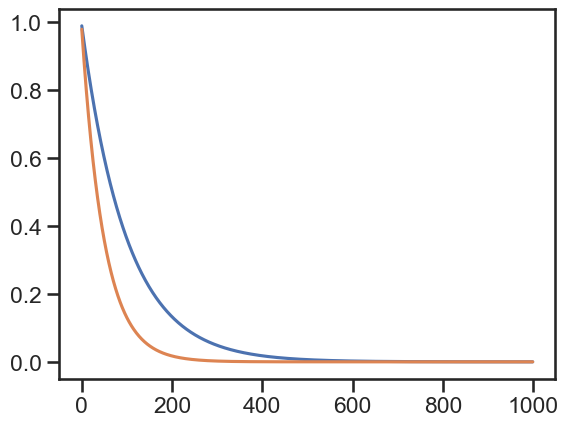

In [3]:
def solve(a_0, k, cats, dt):
    return lax.scan(lambda a_n, cat: (a_n - dt * k * cat * a_n, a_n - dt * k * cat * a_n), a_0, cats)[1]

def solve_cat(cat_0, k_d, dt, n):
    return lax.scan(lambda cat_n, _: (cat_n - dt * k_d * cat_n, cat_n - dt * k_d * cat_n), cat_0, length=n)[1]
    

plt.plot(solve(1.0, 1.0, jnp.ones((1000,)), 0.01))
plt.plot(solve_cat(1.0, 1.0, 0.02, 1000))

Now a simple model, first without worrying about measurement error. We'll use both MCMC and SVI.

In [57]:
def model(a_0, cat_0, dt, n):
    k = sample('k', dist.LogNormal(0.0, 0.5))
    k_d = sample('k_d', dist.LogNormal(-3.0, 0.5))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))

args = (1.0, 1.0, 0.01, 500)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 7287.78it/s, init loss: 26.6421, avg. loss [1901-2000]: 0.0119]


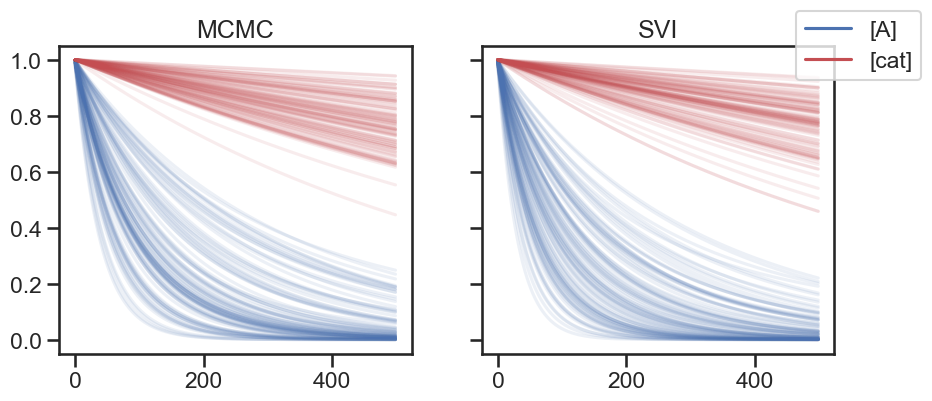

In [59]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
f.legend(handles=[a_line, cat_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)

Very nice, we get a range of $[A]$ trajectories based on possible $k$'s but also $k_d$'s. But now let's just sample simulate adding measurement error as a `LogNormal`. The previous variables shouldn't be affected because we are not making an observation. What's notable about this `a_draw` variable is that it has a very narrow distribution ($\sigma$ = 0.02).

In [60]:
def model(a_0, cat_0, dt, n, err):
    k = sample('k', dist.LogNormal(0.0, 0.5))
    k_d = sample('k_d', dist.LogNormal(-5.0, 0.5))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))
    a_draw = sample('a_draw', dist.LogNormal(jnp.log(a_n), err))

args = (1.0, 1.0, 0.01, 500, 0.02)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 3496.48it/s, init loss: 6657175.0000, avg. loss [1901-2000]: 1581.4250]


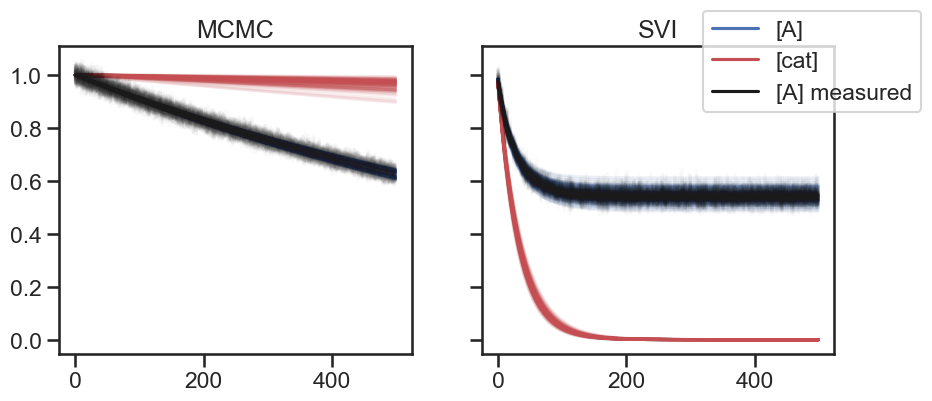

In [64]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
meas_line, *_ = a1.plot(mcmc_samples['a_draw'].T, c='k', alpha=0.02, label='[A] measured')
meas_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
a2.plot(svi_samples['a_draw'].T, c='k', alpha=0.02)
f.legend(handles=[a_line, cat_line, meas_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)
meas_line.set_alpha(0.02)

Yes, not looking good at all. We were expecting the exact sample plots! Increasing the number of samples, warmup, SVI steps doesn't help either. The culprit is clearly the narrow distribution as increasing its std to 1.0 everything goes back to normal.

After a bit of head scratching, it turns out there is a way to fix this without rewriting the model and manually de-centering/scaling. This happens on the level of the `Normal` distributions being sampled with ($\mu = 0$ and $\sigma = 1.0$) but the `LogNormal` distribution is a further exponential transform away from so that's where `TransformReparam` comes in.

In [68]:
reparam_config = {
    'k': reparam.TransformReparam(),
    'k_d': reparam.TransformReparam(),
    'a_draw': reparam.TransformReparam(),
    'k_base': reparam.LocScaleReparam(0),
    'k_d_base': reparam.LocScaleReparam(0),
    'a_draw_base': reparam.LocScaleReparam(0),
}

def model(a_0, cat_0, dt, n, err):
    k = sample('k', dist.LogNormal(0.0, 0.5))
    k_d = sample('k_d', dist.LogNormal(-5.0, 0.5))
    cats = deterministic('cat', solve_cat(cat_0, k_d, dt, n))
    a_n = deterministic('a_n', solve(a_0, k, cats, dt))
    a_draw = sample('a_draw', dist.LogNormal(jnp.log(a_n), err))

model = handlers.reparam(model, reparam_config)

args = (1.0, 1.0, 0.01, 500, 0.02)
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=100)
mcmc.run(PRNGKey(0), *args)
mcmc_samples = mcmc.get_samples()

guide = autoguide.AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())
svi_result = svi.run(PRNGKey(1), 2000, *args)
svi_samples = guide.sample_posterior(PRNGKey(0), svi_result.params, sample_shape=(100,))

100%|██████████| 2000/2000 [00:00<00:00, 4569.60it/s, init loss: 1233.4703, avg. loss [1901-2000]: 2.5142]


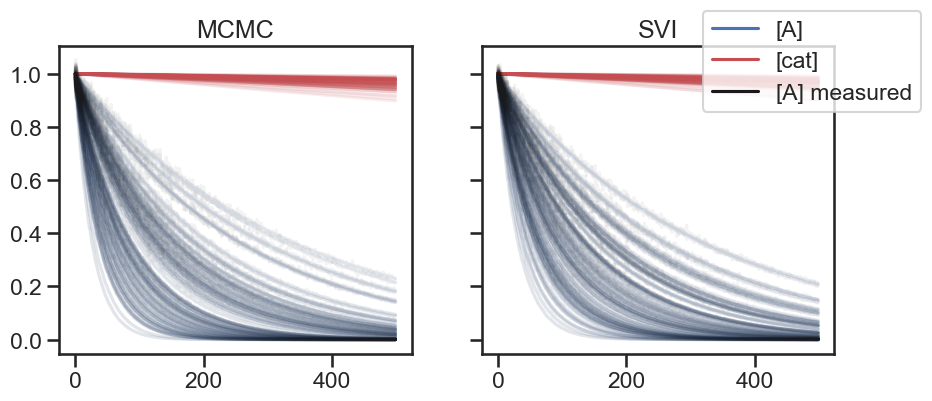

In [69]:
f, (a1, a2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
a1.set_title('MCMC')
a2.set_title('SVI')

a_line, *_ = a1.plot(mcmc_samples['a_n'].T, c='b', alpha=0.1, label='[A]')
a_line.set_alpha(1)
cat_line, *_ = a1.plot(mcmc_samples['cat'].T, c='r', alpha=0.1, label='[cat]')
cat_line.set_alpha(1)
meas_line, *_ = a1.plot(mcmc_samples['a_draw'].T, c='k', alpha=0.05, label='[A] measured')
meas_line.set_alpha(1)
a2.plot(svi_samples['a_n'].T, c='b', alpha=0.1)
a2.plot(svi_samples['cat'].T, c='r', alpha=0.1)
a2.plot(svi_samples['a_draw'].T, c='k', alpha=0.05)
f.legend(handles=[a_line, cat_line, meas_line])
a_line.set_alpha(0.1)
cat_line.set_alpha(0.1)
meas_line.set_alpha(0.02)

Beautiful! The latent concentrations are now exactly as before and we also have a nice extra variable showing measurement with error.

You will notice a quirk: I had to know that the name of the underlying `Normal` site Now one downside of using this automatic reparameterisation is that `TransformReparam` doesn't currently support observations. That's fine though, you can split the sampled and observed parts (the observed part won't need reparameterising as it won't need to be sampled).

Anyway, depending on your background this may seem very dense or trivial and I wish there was more time to expand and properly discuss but that will have to wait util another time.